In [5]:
from astropy.coordinates import SkyCoord, HeliocentricMeanEcliptic, BarycentricMeanEcliptic, BarycentricTrueEcliptic
from astropy.coordinates import get_body_barycentric
from astropy.time import Time
from astroquery.jplhorizons import Horizons

import astropy.units as u

import numpy as np
import matplotlib.pyplot as plt

def get_parallax_vector(t_in_days):
    earth = Horizons(id='399', 
                   location='500@0',
                   epochs=2451545.0)
    obj = Horizons(id="90377;",
                   location="500@0",
                   epochs=2451545.0)

    vx,vy,vz = earth.vectors()['vx'],earth.vectors()['vy'],earth.vectors()['vz']
    x,y,z = obj.vectors()['x'],obj.vectors()['y'],obj.vectors()['z'] 
    x_0 = np.array([x,y,z])
    v = np.array([vx,vy,vz])
    parallax = x_0 + v * t_in_days
    # parallax points in the opposite direction of the velocity
    return -1 * parallax
    

In [6]:
from numpy import radians, sin, cos
RA_CENTER_IDX = 512
DEC_CENTER_IDX = 512
DEG_PER_PIXEL = 0.25 / 3600
from tqdm import tqdm

import numpy as np

def to_rotation_matrix(inclination, ascending_node):
    # Calculate trigonometric values
    cos_i = np.cos(inclination)
    sin_i = np.sin(inclination)
    cos_o = np.cos(ascending_node)
    sin_o = np.sin(ascending_node)
     
    # Ecliptic tilt (Earth's axial tilt)

    
    # Define the rotation matrices
    inclination_matrix = np.array([
        [1.0, 0.0, 0.0],
        [0.0, cos_i, -sin_i],
        [0.0, sin_i, cos_i]
    ])

    ascending_node_matrix = np.array([
        [cos_o, -sin_o, 0.0],
        [sin_o, cos_o, 0.0],
        [0.0, 0.0, 1.0]
    ])

    # Perform matrix multiplication
    rotation_matrix = (inclination_matrix @ ascending_node_matrix)
    
    return rotation_matrix


def trace_path_across_image(image, ra_center, dec_center, orbital_elements, parallax_vector):
    axial_tilt = np.radians(23.44)
    cos_tilt = np.cos(axial_tilt)
    sin_tilt = np.sin(axial_tilt)

    tilt_matrix = np.array([
        [1.0, 0.0, 0.0],
        [0.0, cos_tilt, sin_tilt],
        [0.0, -sin_tilt, cos_tilt]
    ])

    output = np.zeros_like(image)
    for i in tqdm(range(len(image))):
        for j in range(len(image[i])):
            # so what we want to do is find the ra/dec of a pixel
            dec_current = dec_center + (i - DEC_CENTER_IDX) * DEG_PER_PIXEL
            ra_current = ra_center + (j - RA_CENTER_IDX) * DEG_PER_PIXEL
            dec_current = radians(dec_current)
            ra_current = radians(ra_current)
            x = cos(dec_current) * cos(ra_current)
            y = cos(dec_current) * sin(ra_current)
            z = sin(dec_current)

            # x,y,z = tilt_matrix @ np.array([x, y, z])

            # the above are geocentric coordinates expressed relative to the ecliptic, but we want heliocentric coords since orbital elements are heliocentric
            # so we need to fetch earth's position w.r.t the sun using Horizons
            # we can do this by using the JPL Horizons API

            # x_earth, y_earth, z_earth = (-0.17713507,  0.88742852,  0.38474289)
            x_parallax, y_parallax, z_parallax = parallax_vector
            x -= x_parallax
            y -= y_parallax 
            z -= z_parallax 

            mat = to_rotation_matrix(radians(orbital_elements["inclination"]), radians(orbital_elements["ascending_node"]))
            z_p = mat[2][0] * x + mat[2][1] * y + mat[2][2] * z
            if abs(z_p) < 1e-6:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output 

In [34]:
# IMG_DIM = RA_CENTER_IDX * 2 + 1
# image = [[0 for i in range(IMG_DIM)] for j in range(IMG_DIM)]
# path = trace_path_across_image(image, 0, 0)
# path


# # view as image
# import matplotlib.pyplot as plt
# plt.imshow(image)
# plt.show()

to_rotation_matrix(23.44, 12)

# axial_tilt = np.radians(23.44)
# cos_tilt = np.cos(axial_tilt)
# sin_tilt = np.sin(axial_tilt)

# tilt_matrix = np.array([
#     [1.0, 0.0, 0.0],
#     [0.0, cos_tilt, sin_tilt],
#     [0.0, -sin_tilt, cos_tilt]
# ])

# tilt_matrix

array([[ 0.84385396,  0.53657292,  0.        ],
       [ 0.06527028, -0.10264884,  0.99257393],
       [ 0.53258829, -0.83758744, -0.1216429 ]])

100%|██████████| 1024/1024 [00:10<00:00, 101.09it/s]


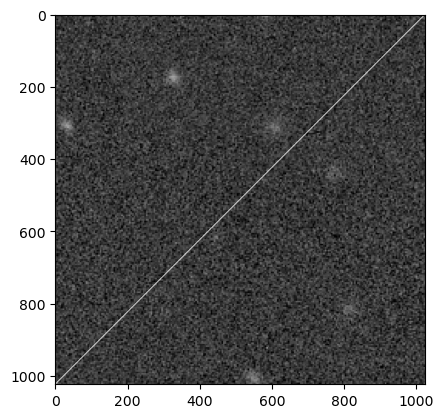

In [67]:
# open test.jpeg as a numpy array
import numpy as np
from PIL import Image


img = Image.open("test.jpeg")
img = np.array(img)


for i in range(0, 1):
    for j in range(0, 1):
        path = trace_path_across_image(img, i, j, {
            "periapsis": 0,
            "ascending_node": 0,
            "inclination": 45 
        }, (0, 0, 0))
        plt.imshow(path, cmap="gray")
        plt.show()
    



In [ ]:

axial_tilt = np.radians(23.44)
cos_tilt = np.cos(axial_tilt)
sin_tilt = np.sin(axial_tilt)

tilt_matrix = np.array([
    [1.0, 0.0, 0.0],
    [0.0, cos_tilt, sin_tilt],
    [0.0, -sin_tilt, cos_tilt]
])

# takes an array of images, across time
def mask_noisy_image(images, ra_center, dec_center, orbital_elements):
    # Create coordinate grids
    i_coords, j_coords = np.indices(images[0].shape)
    
    # Calculate dec and ra for all points simultaneously
    dec_current = dec_center + (i_coords - DEC_CENTER_IDX) * DEG_PER_PIXEL
    ra_current = ra_center + (j_coords - RA_CENTER_IDX) * DEG_PER_PIXEL
    
    # Convert to radians
    dec_current = np.radians(dec_current)
    ra_current = np.radians(ra_current)
    
    # Calculate cartesian coordinates for all points
    x = np.cos(dec_current) * np.cos(ra_current)
    y = np.cos(dec_current) * np.sin(ra_current)
    z = np.sin(dec_current)
    
    # Stack coordinates into a 3D array of shape (3, height, width)
    coords = np.stack([x, y, z])
    
    # Apply tilt matrix transformation using broadcasting
    # Assuming tilt_matrix is a 3x3 matrix
    coords_transformed = np.einsum('ij,jkl->ikl', tilt_matrix, coords)
    
    # Subtract Earth's position (broadcasting automatically)
    earth_pos = np.array([[-0.17713507], [0.88742852], [0.38474289]])
    coords_transformed = coords_transformed - earth_pos.reshape(3, 1, 1)
    
    # Create rotation matrix from orbital elements
    mat = to_rotation_matrix(
        radians(orbital_elements["inclination"]),
        radians(orbital_elements["ascending_node"]),
    )
    
    # Calculate z_p for all points using matrix multiplication
    z_p = np.einsum('i,ikl->kl', mat[2], coords_transformed)
    
    # Find points where z_p is close to zero
    path_mask = np.abs(z_p) < 1e-6
    
    # Convert mask to pixel coordinates
    path_pixels = np.where(path_mask)

 


In [ ]:
image = np.array(Image.open("test.jpeg"))

images_to_stack = []
centers = [(i,j) for i in range(-90, 90) for j in range(-90, 90)]

for i,j in centers:
    path = stack_across_path_vectorized(image, i, j, {
        "ascending_node": 144.25847763982,
        "inclination": 11.93034000
    })

    # i_0, j_0 = path[0]
    # image[i_0][j_0] = sum([image[i_path][j_path] for i_path, j_path in path])           

KeyboardInterrupt: 

100%|██████████| 1024/1024 [00:10<00:00, 100.10it/s]


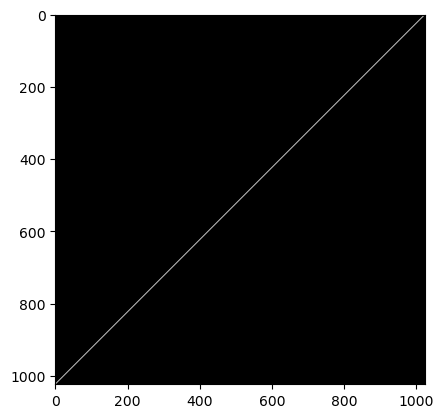

100%|██████████| 1024/1024 [00:10<00:00, 99.07it/s]


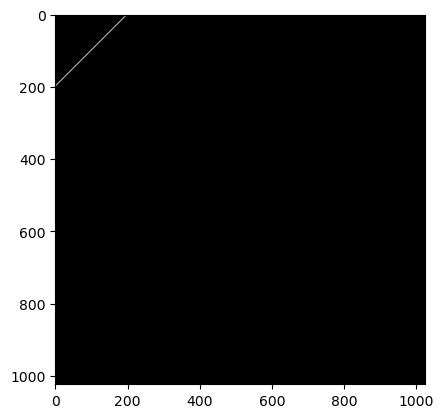

In [ ]:
image_1 = np.zeros((1024, 1024))
image_2 = np.zeros((512*2, 512*2))



path1 = trace_path_across_image(image_1, 0, 0, {
    "ascending_node": 0,
    "inclination": 45
}, (0, 0, 0))

plt.imshow(path1, cmap="gray")
plt.show()

path2 = trace_path_across_image(image_2, 0, 0, {
    "ascending_node": 0,
    "inclination": 45 
}, (-0.002, -0.001, 0))

plt.imshow(path2, cmap="gray")
plt.show()

In [75]:
from astroquery.jplhorizons import Horizons
def get_test_parallax_vector():
    t_0_julian = 2451545.0
    t_1_julian = 2451545.0 + 5
    
    jpl_earth_pos = Horizons(id='399', 
                            location='500@0',
                            epochs=t_0_julian)
    jpl_earth_pos2 = Horizons(id="399",
                            location="500@0",
                            epochs=t_1_julian)
    
    earth_pos = jpl_earth_pos.vectors()['x'],jpl_earth_pos.vectors()['y'],jpl_earth_pos.vectors()['z']
    earth_pos2 = jpl_earth_pos2.vectors()['x'],jpl_earth_pos2.vectors()['y'],jpl_earth_pos2.vectors()['z']
    parallax = (earth_pos[0] - earth_pos2[0], earth_pos[1] - earth_pos2[1], earth_pos[2] - earth_pos2[2])
    return parallax

In [76]:
get_test_parallax_vector()

(<MaskedColumn name='X' dtype='float64' length=1>
 0.08521906369570598,
 <MaskedColumn name='Y' dtype='float64' length=1>
 0.019586879442077376,
 <MaskedColumn name='Z' dtype='float64' length=1>
 -1.5084783799501004e-06)

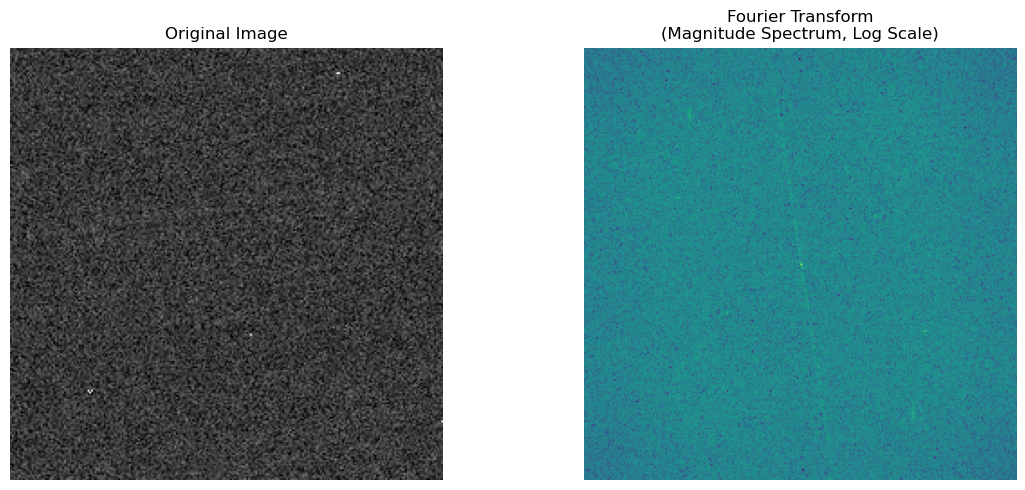

In [12]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Your existing code
image_to_transform = Image.open("fourier.jpeg")
fourier_transform = np.fft.fft2(np.array(image_to_transform))

# Shift the zero-frequency component to the center
fourier_transform_shifted = np.fft.fftshift(fourier_transform)

# Calculate the magnitude spectrum and apply log scaling
magnitude_spectrum = np.log(1 + np.abs(fourier_transform_shifted))

# Create a figure with two subplots side by side
plt.figure(figsize=(12, 5))

# Display original image
plt.subplot(121)
plt.imshow(image_to_transform, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Display Fourier transform
plt.subplot(122)
plt.imshow(magnitude_spectrum, cmap='viridis')
plt.title('Fourier Transform\n(Magnitude Spectrum, Log Scale)')
plt.axis('off')

plt.tight_layout()
plt.show()

TypeError: Image data of dtype complex128 cannot be converted to float

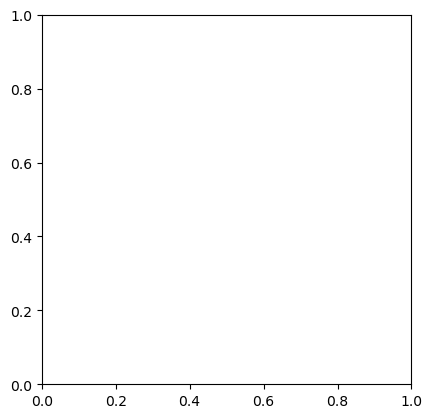